## MCMC Convergence/Autocorrelation
This notebook runs a chain for the fiducial cosmology for about 10e^6 samples and looks at the autocorrelation time $\tau$ each 100 iterations. In general we want at least $100\tau$ samples. We will assume the autocorrelation time is similar for each cosmology. We can always choose a conservative estimate for the number of samples to ensure the chains converge.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getdist import plots, MCSamples
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples

import sys
import time
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

from numpy import linalg
import scipy

%matplotlib notebook

In [2]:
### Functions
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
    #plt.show()
    
def add_bias(bias_theta, datavector):
    for i in range(5):
        factor = (bias_theta[i] / bias_fid[i])**bias_mask[i]
        datavector = factor * datavector
    return datavector

def add_shear_calib(m, datavector):
    for i in range(5):
        factor = (1 + m[i])**shear_calib_mask[i]
        datavector = factor * datavector
    return datavector

def hard_prior(theta, params_prior):
    """
    A function to impose a flat prior on a set of parameters.
    :theta: The set of parameter values
    :params_prior: The minimum and the maximum value of the parameters on which this prior is imposed
    """
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
cosmo_prior_lim = np.array([[1.61, 3.91],
                       [0.87, 1.07],
                       [55, 91],
                       [0.01, 0.04],
                       [0.001, 0.99]])

ia_prior_lim = np.array([[-5., 5.],
                       [-5., 5.]])

bias_prior_lim = np.array([[0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.]])

baryon_prior_lim = np.array([[-3., 12.],
                             [-2.5, 2.5]])

baryon_prior_lim = 3. * baryon_prior_lim 

dz_source_std   = 0.002 * np.ones(5)
dz_lens_std     = 0.005 * np.ones(5)
shear_calib_std = 0.005 * np.ones(5)
    
def lnprior(theta):
    cosmo_theta = theta[:5]
    ns          = cosmo_theta[1]

    ns_prior    = 0.
    
    dz_source   = theta[5:10]
    ia_theta    = theta[10:12]
    dz_lens     = theta[12:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    
    cosmo_prior = hard_prior(cosmo_theta, cosmo_prior_lim) + ns_prior
    ia_prior    = hard_prior(ia_theta, ia_prior_lim)
    bias_prior  = hard_prior(bias, bias_prior_lim)
    baryon_prior = hard_prior(baryon_q, baryon_prior_lim)
    
    dz_source_lnprior   = -0.5 * np.sum((dz_source / dz_source_std)**2)
    dz_lens_lnprior     = -0.5 * np.sum((dz_lens / dz_lens_std)**2)
    shear_calib_lnprior = -0.5 * np.sum((shear_calib / shear_calib_std)**2)
    
    return cosmo_prior + ia_prior + dz_source_lnprior + dz_lens_lnprior + \
            shear_calib_lnprior + bias_prior + baryon_prior
    
def ln_lkl(theta):
    model_datavector = get_data_vector_emu(theta)
    delta_dv = (model_datavector - data_model.dv_obs)[data_model.mask_3x2]
    return -0.5 * delta_dv @ data_model.masked_inv_cov @ delta_dv

def lnprob(theta):
    return lnprior(theta) + ln_lkl(theta)

def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    return datavector

In [37]:
N_WALKERS     = 120
N_MCMC        = 100000
N_SAMPLES     = N_WALKERS*N_MCMC
NDIM_SAMPLING = 29

In [38]:
### Get the necessary data for likelihood

# Get the LSST covariance and fid data
path = '/home/grads/data/evan/tension_calibration/data/lsst_y1/'
lsst_cov = np.loadtxt(path+'cov_lsst_y1')
fid_cos = np.loadtxt(path+'lsst_y1_data_fid',dtype=np.float32)[:,1]

lsst_y1_cov = np.zeros((1560, 1560))
for line in lsst_cov:
    i = int(line[0])
    j = int(line[1])

    cov_g_block  = line[-2]
    cov_ng_block = line[-1]

    cov_ij = cov_g_block + cov_ng_block

    lsst_y1_cov[i,j] = cov_ij
    lsst_y1_cov[j,i] = cov_ij
    
fid = torch.Tensor(fid_cos)
cov = torch.Tensor(lsst_y1_cov)

# Code taken from the emulator notebook
#first the fiducial cosmology

configfile = 'configs/nn_emu.yaml'
config = Config(configfile)

config_args     = config.config_args
config_args_io  = config_args['io']
config_args_data = config_args['data']

savedir = 'output/nn_emu/'

N_DIM         = 17
data_model    = LSST_3x2(N_DIM, config_args_io, config_args_data)
data_model.emu_type = 'nn'
OUTPUT_DIM = 1560

emu = NNEmulator(N_DIM, OUTPUT_DIM, data_model.dv_fid, data_model.dv_std)    
emu.load('model/nn_emu/model')
# ======================================================

data_model.emu = emu

bias_fid         = data_model.bias_fid
bias_mask        = data_model.bias_mask
shear_calib_mask = data_model.shear_calib_mask

theta0    = np.array([3.0675, 0.97, 69.0, 0.0228528, 0.1199772, 
                      0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.])

theta_std = np.array([0.01, 0.001, 0.1, 0.001, 0.002, 
                      0.002, 0.002, 0.002, 0.002, 0.002, 
                      0.1, 0.1,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.03, 0.03, 0.03, 0.03, 0.03,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.1, 0.1]) 

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + 3. * theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

In [46]:
autocorr       = np.zeros(N_MCMC)
autocorr_ratio = np.zeros(N_MCMC)
autocorr_diff = np.zeros(N_MCMC)

index = 0
old_tau=np.inf
aold_tau=0

print('--- MCMC ---')
print('N_iterations = {}'.format(N_MCMC))
print('N_walkers = {}'.format(N_WALKERS))
print('N_samples = {}\n'.format(N_SAMPLES))

with Pool(10) as pool:
    emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    
    for sample in emu_sampler.sample(pos0, iterations=N_MCMC, progress=True):
        if emu_sampler.iteration % 1000:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = emu_sampler.get_autocorr_time(tol=0)
        atau = np.mean(tau)
        autocorr[index] = atau
        autocorr_ratio[index] = atau/aold_tau
        autocorr_max[index] = np.amax(tau)/np.amax(aold_tau)
        index += 1

        old_tau = tau
        aold_tau = np.mean(old_tau)

--- MCMC ---
N_iterations = 100000
N_walkers = 120
N_samples = 12000000



  1%|▌                                                      | 1000/100000 [01:10<1:52:29, 14.67it/s]/home/grads/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars
/home/grads/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
100%|█████████████████████████████████████████████████████| 100000/100000 [2:39:00<00:00, 10.48it/s]


<IPython.core.display.Javascript object>


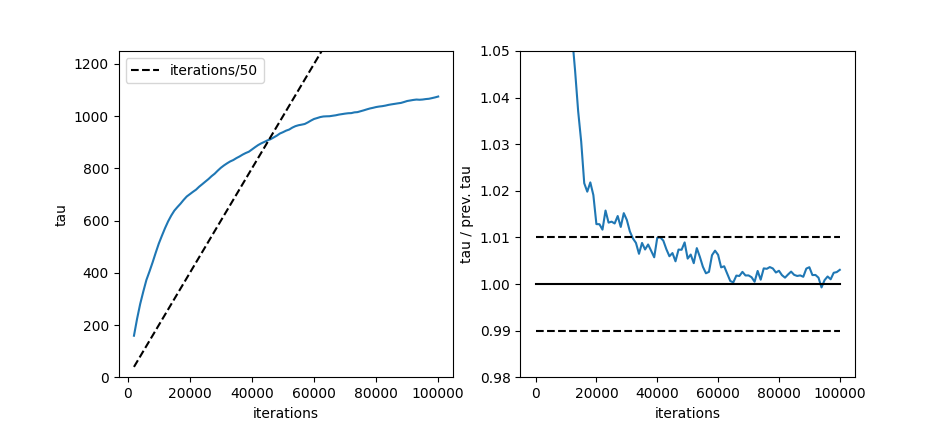

[  2000   3000   4000   5000   6000   7000   8000   9000  10000  11000
  12000  13000  14000  15000  16000  17000  18000  19000  20000  21000
  22000  23000  24000  25000  26000  27000  28000  29000  30000  31000
  32000  33000  34000  35000  36000  37000  38000  39000  40000  41000
  42000  43000  44000  45000  46000  47000  48000  49000  50000  51000
  52000  53000  54000  55000  56000  57000  58000  59000  60000  61000
  62000  63000  64000  65000  66000  67000  68000  69000  70000  71000
  72000  73000  74000  75000  76000  77000  78000  79000  80000  81000
  82000  83000  84000  85000  86000  87000  88000  89000  90000  91000
  92000  93000  94000  95000  96000  97000  98000  99000 100000]
[ 89.47387292 159.43601206 223.93897935 ...   0.           0.
   0.        ]


(0.98, 1.05)

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
n = 1000 * np.arange(2, index + 1)
print(n)
print(autocorr)

ax1.plot(n,autocorr[1:index])
ax1.plot(n,n/50,'k--',label='iterations/50')
ax1.set_ylabel('tau')
ax1.set_xlabel('iterations')
ax1.set_ylim(0,1250)
ax1.legend()
ax2.plot(n,autocorr_ratio[1:index])
ax2.plot([0,N_MCMC],[1,1],color='k')
ax2.plot([0,N_MCMC],[0.99,0.99],'k--')
ax2.plot([0,N_MCMC],[1.01,1.01],'k--')
ax2.set_xlabel('iterations')
ax2.set_ylabel('tau / prev. tau')
ax2.set_ylim(0.98,1.05)
#ax3.plot(n,autocorr_diff[1:index])
#ax3.set_ylim(-0.01,1.1)

In [ ]:
print(len(autocorr[:index]))